#0. Loading Data and importing Library
**PLEASE READ!!** : 

THERE ARE 3 PARAMETERS TO MODIFY IN MODEL
1. MODEL_NAME
2. seg_bool
3. MODEL_SAVE_PATH 



---


THERE ARE ANOTHER 2 PARAMETERS TO MODIFY IN LOAD
1. MODEL_LOAD_NAME
2. seg_bool_load
3. MODEL_LOAD_PATH


---


Please add the [FOLDER](https://drive.google.com/drive/folders/1nrhaTZC-0wGPOKA1ZwVdmmB2U1NqrMsJ?usp=sharing) to your root directory of Google Drive.
[paper link](https://www.researchgate.net/publication/330154837_Ripeness_Classification_of_Bananas_Using_an_Artificial_Neural_Network
)

also please join [trello](https://trello.com/b/uPv9MgUv/ml-proj-banana)

Data arr; dataset, dataset_label

data_processed

In [ ]:
#TO RUN
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#TO RUN
import sys
import os
# sys.path.append('/content/drive/MyDrive/Project/')
if (os.getcwd() == '/content'): 
    os.chdir('./drive/MyDrive/Project')

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#TO RUN
import os
import math
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#image filter
from skimage import filters, color
from skimage.color import hsv2rgb
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
from skimage.color import gray2rgb

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import cv2

from itertools import repeat
from collections import Counter

from numpy.random import seed
#model
import tensorflow as tf
from tensorflow import keras
from tensorflow.random import uniform
from tensorflow_addons.image import rotate
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation, Permute, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, LeakyReLU
from keras.layers import SeparableConv2D, DepthwiseConv2D, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout2D
from keras.layers import Flatten, Input
from keras.regularizers import l1_l2
from keras.constraints import max_norm
from keras.models import Sequential

### Set Seed

In [ ]:
seed(23)
tf.keras.utils.set_random_seed(23)

# 1. Load Data

In [ ]:
#TO RUN: load dataset
PATH='Fayoum_University_Banana _Classes'
folder_name = os.listdir(PATH)
dataset = []

# Green 104 Yellowish_green 48 Midripen 88 Overripen 33
data_keys = ('g','y','m','v')
dataset_label = []

for name in sorted(folder_name):
  subfolder = os.path.join(PATH, name)
  for fh in sorted(os.listdir(subfolder)):
    file_name = os.path.join(subfolder,fh)
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)
    dataset.append(img)
    dataset_label.append(data_keys.index(fh[0]))

## Show images

In [ ]:
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

g


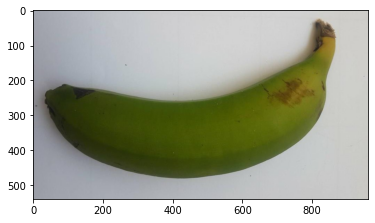

In [ ]:
plt.imshow(bgr2rgb(dataset[0]))
print(data_keys[dataset_label[0]])

v


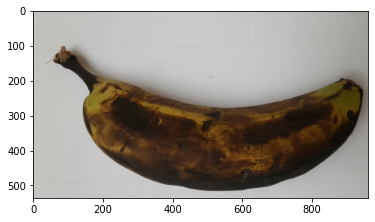

In [ ]:
plt.imshow(bgr2rgb(dataset[220]))
print(data_keys[dataset_label[220]])

m


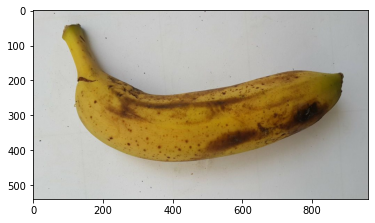

In [ ]:
plt.imshow(bgr2rgb(dataset[161]))
print(data_keys[dataset_label[161]])

y


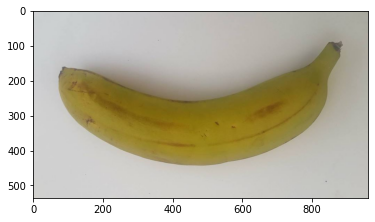

In [ ]:
plt.imshow(bgr2rgb(dataset[-5]))
print(data_keys[dataset_label[-5]])

# 2. Image Preprocessing

Also, cv2 input will be in bgr instead of rgb, use bgr2rgb function helper to convert it, then use plt to plot

Find the highest occurences of shapes

In [ ]:
c = Counter([ele.shape for ele in dataset])
c

Counter({(540, 960, 3): 118,
         (1072, 1920, 3): 1,
         (536, 960, 3): 153,
         (636, 960, 3): 1})

In [ ]:
#TO RUN: def function for preprocessing image
# cv2 width height reversed https://stackoverflow.com/a/22094421
def ProcessImage(img, ker=5):
  """
    Apply Gaussian blur to the image 
    input :
      img : the image to be processed
      ker : the kernel, has to be odd numbered
  """
  img = cv2.GaussianBlur(img,(5,5),0)
  return img


In [ ]:
# BGR
data_processed = np.array(list(map(ProcessImage, dataset)),dtype=object)

In [ ]:
c = Counter([ele.shape for ele in data_processed])
c

Counter({(540, 960, 3): 118,
         (1072, 1920, 3): 1,
         (536, 960, 3): 153,
         (636, 960, 3): 1})

#3. Fruit Segmentation (NOTUSED) please hide collapse this cell


## Helper Func

Both cv2 and skimg segment works, but use skimg instead

In [ ]:
def hsv2gray(img):
    return rgb2gray(hsv2rgb(img))
def gray2hsv(img):
    return rgb2hsv(gray2rgb(img))
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def gray2bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
def bgr2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
def HSV_to_cv(h,s,v):
    return (h/2, s/100 * 255, v/100 * 255)

### Hidden cv2

In [ ]:
def show_intensity_histogram(image):
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.hist(image_grayscale.ravel(), 256)
    plt.title('Intensity histogram')
    plt.ylabel('Number of pixels')
    plt.xlabel('Light intensity')
    plt.show()

In [ ]:
# also works, but use skimage filter instead
# https://stackoverflow.com/questions/59235904/how-to-remove-shadows-from-foreground-after-segmentation
def show_mask(mask, image, title='', mask_color=(0, 0, 0)):
    display_image = image.copy()
    display_image[mask != 0] = mask_color
    plt.imshow(display_image)
    plt.title(title)
    plt.axis('off')
    plt.show()
    return display_image
    
def compute_otsu_mask(image):
  image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return cv2.threshold(image_grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


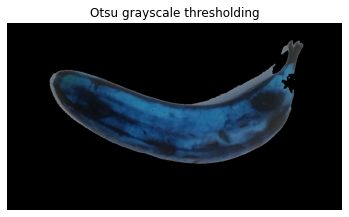

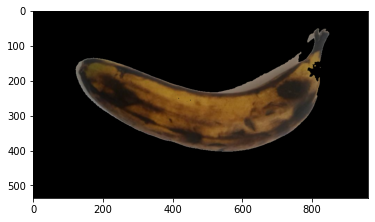

In [ ]:
# l = np.random.randint(0,272)
# print(l)
# c = data_processed[64]
c = data_processed[214]
mask_otsu = compute_otsu_mask(c)
val = show_mask(mask_otsu, c, title='Otsu grayscale thresholding')
plt.imshow(bgr2rgb(val))

## Banana Segmented

In [ ]:
def segmentation_mask_skimg(img):
    image = bgr2gray(img)
    thresh = filters.threshold_otsu(image)
    mask = (image <= thresh).astype(int)
    return mask
def segment_image_skimg(img):
    mask = segmentation_mask_skimg(img)
    masked = np.zeros_like(img)
    for i in range(3): 
        masked[:,:,i] = np.where(mask, img[:,:,i], 0)
    return masked

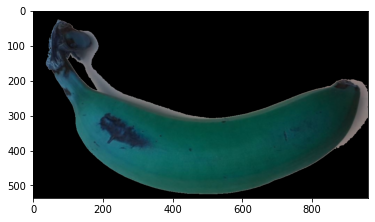

In [ ]:
img = data_processed[64]
v = segment_image_skimg(img)
plt.imshow(v)

In [ ]:
def remove_shadow(image, lower = [0, 60, 0], upper = [179, 255, 255]):
    # (hMin = 0 , sMin = 60, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
    blank_mask = np.zeros_like(image)
    original = image.copy()
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = np.array(lower)
    upper = np.array(upper)
    mask = cv2.inRange(hsv, lower, upper)

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        cv2.drawContours(blank_mask,[c], -1, (255,255,255), -1)
        break

    result = cv2.bitwise_and(original,blank_mask)
    return result

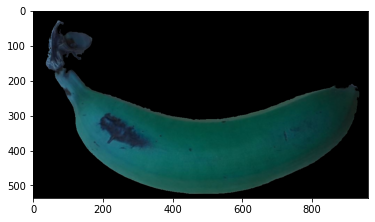

In [ ]:
plt.imshow(remove_shadow(v))

In [ ]:
def segment_image(img):
    
    return remove_shadow(segment_image_skimg(img))

In [ ]:
def segment_brown_spot(img):
    return remove_shadow(img, [HSV_to_cv(30, 66, 4.7)], [HSV_to_cv(30, 67.6, 60)])

In [ ]:
data_segmented = np.array(list(map(segment_image, data_processed)))

<ipython-input-27-bd1b00f1b93a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_segmented = np.array(list(map(segment_image, data_processed)))


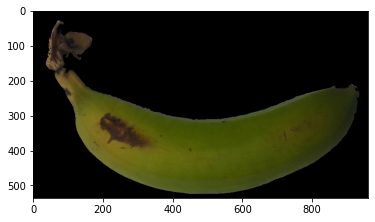

In [ ]:
# Tester Here # some pic might looks bad cause the remove_shadow part does not apply to all banana, but it is usable...
rand = np.random.randint(200,274)
# plt.imshow(bgr2rgb(data_segmented[216]))
v=bgr2rgb(segment_image(ProcessImage(dataset[64])))
plt.imshow(v)

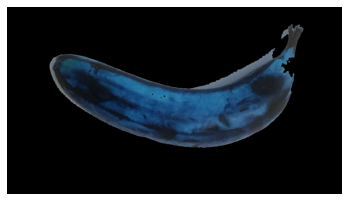

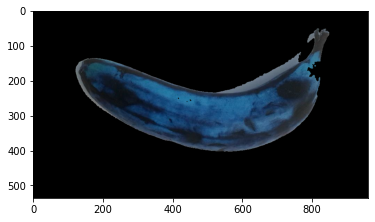

In [ ]:
from skimage.filters import threshold_otsu
from skimage.morphology import opening, closing
from skimage.exposure import equalize_hist
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Open the image file

# Convert the image to a NumPy array
image_data = dataset[214]
image_data = bgr2gray(image_data)
# image_data = equalize_hist(image_data)
image_data = closing(image_data)
image_data = closing(image_data)

# Calculate the optimal threshold using Otsu's method
threshold = threshold_otsu(image_data)

# # Threshold the image to create a binary image
binary_image = image_data > threshold

# # Apply morphological operations to remove noise and smooth the object boundaries
binary_image = opening(binary_image)
binary_image = closing(binary_image)

# plt.imshow(binary_image)
val = show_mask(binary_image, dataset[214])
plt.imshow(val)

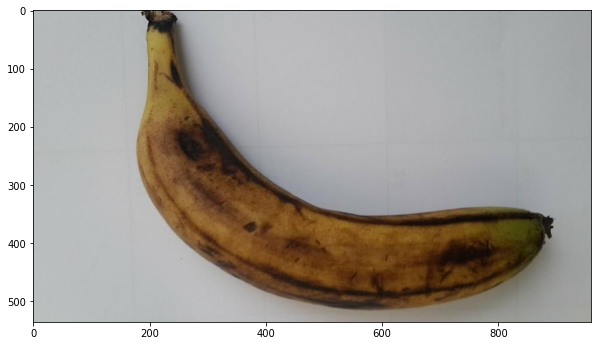

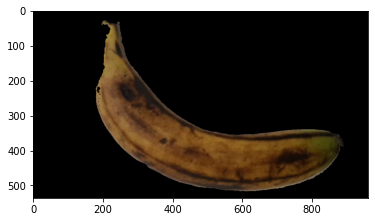

In [ ]:
plt.figure(figsize=(10,10))
val = 222
plt.imshow(bgr2rgb(dataset[val]))
plt.show()
aaa=ProcessImage(dataset[val])

plt.imshow(segment_image(bgr2rgb(aaa)))
plt.show()

#3. Banana Detection using rCNN

uses instance segmentation [link](https://debuggercafe.com/instance-segmentation-with-pytorch-and-mask-r-cnn/)

also use 0.85 for the detection threshold

## Helper for Segmentation

### Library Imports

In [ ]:
import random
import torch
import torchvision
from torchvision.transforms import transforms as transforms
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Label Class Definition

In [ ]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

### Helper Function

In [ ]:
def GetOutputs(image, model, threshold):
  """
    Segment image and get the masks, label and bounding box for that image
    inputs : 
      image : image to be segmented
      model : models that is used to detect where the object is
      threshold : how confident in detecting the image
    
    outputs : 
      masks : the mask of detected object in the image
      boxes : the bounding box of the detected object in the image
      labels : the label of the objects detected in the image
  """
  with torch.no_grad():
      # forward pass of the image through the modle
      outputs = model(image)
  
  # get all the scores
  scores = list(outputs[0]['scores'].detach().cpu().numpy())
  # index of those scores which are above a certain threshold
  thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
  thresholded_preds_count = len(thresholded_preds_inidices)
  # get the masks
  masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  # discard masks for objects which are below threshold
  masks = masks[:thresholded_preds_count]
  # get the bounding boxes, in (x1, y1), (x2, y2) format
  boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
  # discard bounding boxes below threshold value
  boxes = boxes[:thresholded_preds_count]
  # get the classes labels
  labels = [coco_names[i] for i in outputs[0]['labels']]
  return masks, boxes, labels

In [ ]:
def DrawSegmentationMap(image, masks, boxes, labels):
  """
    Draw the bounding box with the label and the segmentation mask in the image
    inputs : 
      image : original image
      masks : the mask of detected object in the image
      boxes : the bounding box of the detected object in the image
      labels : the label of the objects detected in the image
      
    outputs :
      image : with the mask, boxes and labels
  """
  alpha = 1 
  beta = 0.6 # transparency for the segmentation map
  gamma = 0 # scalar added to each sum
  for i in range(len(masks)):
    red_map = np.zeros_like(masks[i]).astype(np.uint8)
    green_map = np.zeros_like(masks[i]).astype(np.uint8)
    blue_map = np.zeros_like(masks[i]).astype(np.uint8)
    # apply a randon color mask to each object
    color = COLORS[random.randrange(0, len(COLORS))]
    red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
    # combine all the masks into a single image
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    #convert the original PIL image into NumPy format
    image = np.array(image)
    # convert from RGN to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # apply mask on the image
    cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
    # draw the bounding boxes around the objects
    cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                  thickness=2)
    # put the label text above the objects
    cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                thickness=2, lineType=cv2.LINE_AA)
  
  return image

### Initialize The Model

In [ ]:
# initialize the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

## Processing The Data for Segmentation

In [ ]:
def Proc(img, thres=0.965):
  """
    Process the image for segmentation using object detection with the rcnn model
    input : 
      img : image as input
      thres : confidence level for the image to detect the object in the image
  """
  # plt.figure()
  image = bgr2rgb(img)
  # keep a copy of the original image for OpenCV functions and applying masks
  orig_image = image.copy()
  # transform the image
  image = transform(image)
  # add a batch dimension
  image = image.unsqueeze(0).to(device)
  masks, boxes, labels = GetOutputs(image, model, thres)
  result = DrawSegmentationMap(orig_image, masks, boxes, labels)
  # plt.imshow(result)
  return masks, boxes, result
  # cv2.imwrite(save_path, result)

In [ ]:
detect_masks, detect_boxes, detect_result = zip(*map(Proc, data_processed, repeat(0.862)))

### Tester (not used) 


In [ ]:
dt_cnt = Counter([len(ele) for ele in detect_masks])
cnt = [(i,len(ele)) for i,ele in enumerate(detect_masks)]

In [ ]:
dt_cnt

Counter({1: 231, 2: 38, 3: 4})

In [ ]:
vvv = list(filter(lambda s: s[1] > 1, cnt))
vvv = [ele[0] for ele in vvv]
vvv

[9,
 12,
 18,
 20,
 23,
 24,
 27,
 28,
 29,
 31,
 36,
 37,
 49,
 51,
 53,
 54,
 55,
 60,
 61,
 64,
 66,
 68,
 70,
 73,
 78,
 89,
 92,
 93,
 94,
 97,
 98,
 106,
 119,
 141,
 224,
 228,
 230,
 235,
 240,
 243,
 246,
 253]

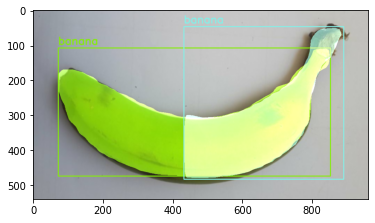

[[(72, 108), (852, 474)], [(432, 47), (890, 483)]]


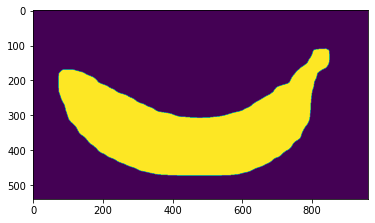

In [ ]:
# just get first filter la
vv=27
a,b,c = detect_masks[vv], detect_boxes[vv], detect_result[vv]
plt.imshow(c)
plt.show()
print(b) 
plt.imshow(a[0])

In [ ]:
# vv60

## Fake (not used)

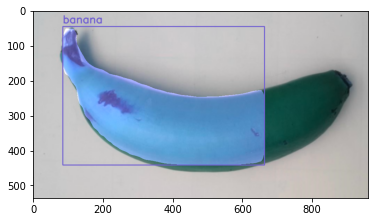

[[(85, 44), (663, 441)]]


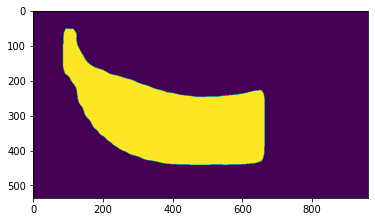

In [ ]:
vv=np.random.choice(vvv)
vv=40 #60
a,b,c = detect_masks[vv], detect_boxes[vv], detect_result[vv]
plt.imshow(c)
plt.show()
print(b) 
plt.imshow(a[0])

[[(26, 229), (716, 512)], [(0, 31), (822, 500)]]


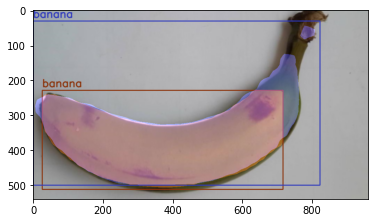

In [ ]:
a,b,c=Proc(data_processed[51])
# b = np.array(b).flatten()
plt.imshow(c)
print(b)
x_min, y_min = b[0][0]
x_max, y_max = b[0][1]
img = data_processed[0][y_min:y_max,x_min:x_max]
# plt.imshow(img)

In [ ]:
# plt.figure(figsize=(18, 18))
# for i in range(9):
#     augmented_image = data_augmentation(image).numpy().astype(int)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_image)
#     plt.axis("off")

## Segment The Image 

In [ ]:
def SegmentImage(mask, box, img):
    # put the mask inside to calculate for the max area, cuz larger threshold doesnt mean it is the banana (false positive)
    """
      Calculate the larger bounding box for larger area, return the image with no background
      inputs : 
        mask : the mask gotten from object detection
        box : the bouding box from object detection
        img : original img
    """
    # plt.figure()
    idx = 0
    max_cnt = 0
    for i, ele in enumerate(mask):
        tmp = np.count_nonzero(ele)
        if (tmp > max_cnt):
            max_cnt = tmp
            idx = i
    # cropping
    # x_min, y_min = box[idx][0]
    # x_max, y_max = box[idx][1]
    # cropped = img[y_min:y_max,x_min:x_max]
    # plt.imshow(img)
    masked = np.zeros_like(img)
    for i in range(3): 
        masked[:,:,i] = np.where(mask[idx], img[:,:,i], 0)

    # is cropped use?
    # return cropped, masked
    return masked
    

In [ ]:
data_segmented = list(map(SegmentImage, detect_masks, detect_boxes, data_processed))

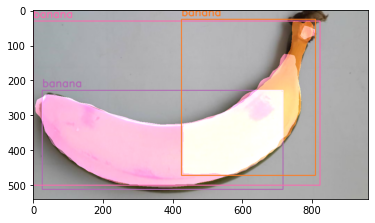

In [ ]:
plt.imshow(bgr2rgb(detect_result[51]))

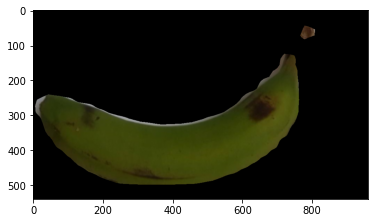

In [ ]:
plt.imshow(bgr2rgb(data_segmented[51]))

## Testing

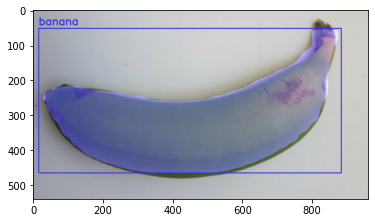

In [ ]:
plt.imshow(bgr2rgb(detect_result[0]))

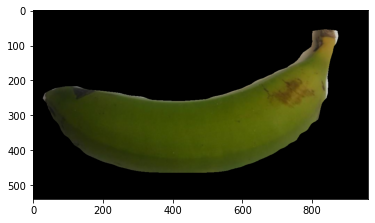

In [ ]:
plt.imshow(bgr2rgb(data_segmented[0]))

# 4. Extracting Fruit Features
(Discontinued, not following the Tamura paper)
ref: https://github.com/MarshalLeeeeee/Tamura-In-Python
https://stackoverflow.com/questions/28421167/tamuras-coarseness-textural-feature


#5. Data Augmentation

In [ ]:
len(data_segmented), len(data_processed), len(dataset_label)

(273, 273, 273)

In [ ]:
type(data_segmented), type(list(data_processed))

(list, list)

In [ ]:
def Augment(img):
  height = img.shape[0]
  width = img.shape[1]

  noise = uniform(shape=[], minval=10, maxval=20)
  aug_img = rotate(img, noise, interpolation= 'nearest', fill_mode='nearest')

  return aug_img

In [ ]:
new_dataset_segmented = data_segmented.copy()
new_dataset_segmented_label = dataset_label.copy()
variation = 2

for idx in range(len(data_segmented)):
  for i in range(variation):
    new_dataset_segmented.append(Augment(data_segmented[idx]))
    new_dataset_segmented_label.append(dataset_label[idx])
    
print(len(new_dataset_segmented))
print(len(new_dataset_segmented_label))

819
819


In [ ]:
new_dataset_processed = list(data_processed.copy())
new_dataset_processed_label = dataset_label.copy()
variation = 2

for idx in range(len(data_processed)):
  for i in range(variation):
    new_dataset_processed.append(Augment(data_processed[idx]))
    new_dataset_processed_label.append(dataset_label[idx])
    
print(len(new_dataset_processed))
print(len(new_dataset_processed_label))

819
819


#6. Model
What we need to compare
1.   ANN - data_segmented: np.array
2.   ANN - data_processed: np.array
3.   CNN - data_segmented: np.array
4.   CNN - data_processed: np.array

Also please reshape it

## Data Preprocessing

In [ ]:
IMAGE_SHAPE = (64, 64, 3)
NUM_CLASSES = 4

### Preprocess X data
ANN & CNN : (1) Resize the image 
      (2) divide pixel value by 255

In [ ]:
def ResizeImage(img, IMG_SIZE):
  if(not isinstance(img, np.ndarray)):
    return cv2.resize(img.numpy(), IMG_SIZE)
  return cv2.resize(img, IMG_SIZE)

In [ ]:
len(np.array(new_dataset_segmented))

819

In [ ]:
MODEL_NAME = 'mobilenet'

In [ ]:
def Preprocess(dataset, img_shape=IMAGE_SHAPE[0:2]):
  data_resized = np.array(list(map(ResizeImage, dataset, repeat(img_shape))))
  dataset_temp = data_resized/255.0
  return dataset_temp

def PreprocessMobileNet(dataset, img_shape=IMAGE_SHAPE[0:2]):
  data_resized = np.array(list(map(ResizeImage, dataset, repeat(img_shape))))
  return np.array(keras.applications.mobilenet_v2.preprocess_input(data_resized))


In [ ]:
dataset_s = None
dataset_p = None
if (MODEL_NAME == 'mobilenet'):
  dataset_s = PreprocessMobileNet(np.array(new_dataset_segmented))
  dataset_p = PreprocessMobileNet(np.array(new_dataset_processed))
else:
  dataset_s = Preprocess(np.array(new_dataset_segmented))
  dataset_p = Preprocess(np.array(new_dataset_processed))

In [ ]:
print(dataset_s.shape)
print(dataset_p.shape)

(819, 64, 64, 3)
(819, 64, 64, 3)


### Preprocess Label
preprocess the label to one-hot encoding


In [ ]:
def OneHot(dataset_label):
  if (type(dataset_label) == list):
    dataset_label = tf.keras.utils.to_categorical(
      dataset_label, num_classes=4, dtype='float32'
    )
  return dataset_label
# dataset_label.shape
dataset_label_s = OneHot(new_dataset_segmented_label)
dataset_label_p = OneHot(new_dataset_processed_label)

In [ ]:
print(dataset_label_s.shape)
print(dataset_label_p.shape)

(819, 4)
(819, 4)


## Shuffle Dataset

In [ ]:
def UnisonShuffleDataset(a, b):
  assert len(a) == len(b)
  p = np.random.RandomState(seed=42).permutation(len(a))
  return a[p], b[p]

dataset_s, dataset_label_s = UnisonShuffleDataset(dataset_s, dataset_label_s)
dataset_p, dataset_label_p = UnisonShuffleDataset(dataset_p, dataset_label_p)

## Split into Train and Validation Data
Split into 80 - 20

In [ ]:
train_len = int(dataset_s.shape[0] * (80/100))
val_len = int(dataset_s.shape[0] * (20/100))
train_len, val_len

(655, 163)

In [ ]:
X_train_s = dataset_s[: train_len]
X_val_s = dataset_s[train_len: ]

X_train_p = dataset_p[: train_len]
X_val_p = dataset_p[train_len: ]

X_train_s.shape, X_val_s.shape

((655, 64, 64, 3), (164, 64, 64, 3))

In [ ]:
y_train_s = dataset_label_s[: train_len]
y_val_s = dataset_label_s[train_len: ]

y_train_p = dataset_label_p[: train_len]
y_val_p = dataset_label_p[train_len: ]

y_train_s.shape, y_val_s.shape

((655, 4), (164, 4))

### Check the occurence of the segmented and processed data

In [ ]:
c = Counter([np.argmax(ele) for ele in y_train_s])
c

Counter({0: 248, 1: 118, 3: 77, 2: 212})

In [ ]:
c = Counter([np.argmax(ele) for ele in y_val_s])
c

Counter({1: 26, 2: 52, 3: 22, 0: 64})

In [ ]:
c = Counter([np.argmax(ele) for ele in y_train_p])
c

Counter({0: 248, 1: 118, 3: 77, 2: 212})

In [ ]:
c = Counter([np.argmax(ele) for ele in y_val_p])
c

Counter({1: 26, 2: 52, 3: 22, 0: 64})

## Model Definition

### CNN and ANN

In [ ]:
def ANN(img_shape = IMAGE_SHAPE):
  """
    Aritifical Neural Network Model Definition
    inputs : 
      img_shape : a tuple of (width, height, channel) of the image, default is (64, 64, 3)
  """
  inputs = Input(shape=img_shape)
  block1 = Flatten()(inputs)
  block1 = Dense(8192, activation='relu')(block1)
  block1 = Dense(1024, activation='relu')(block1)
  block1 = Dense(1024, activation='relu')(block1)
  block1 = Dense(512, activation='relu')(block1)
  outputs = Dense(NUM_CLASSES, activation='softmax')(block1)

  return Model(inputs=inputs, outputs=outputs)

def CNN(img_shape = IMAGE_SHAPE):
  """
    Convolutional Neural Network Model Definition
    inputs : 
      img_shape : a tuple of (width, height, channel) of the image, default is (64, 64, 3)
  """
  inputs = Input(shape=img_shape)
  block1 = Conv2D(32, (3, 3), activation='relu')(inputs)
  block1 = MaxPooling2D((2, 2))(block1)
  block1 = Conv2D(64, (3, 3), activation='relu')(block1)
  block1 = MaxPooling2D((2, 2))(block1)
  block1 = Conv2D(64, (3, 3), activation='relu')(block1)
  flatten = Flatten()(block1)
  block2 = Dense(4096, activation='relu')(flatten)
  block2 = Dense(1024, activation='relu')(block2)
  block2 = Dense(512, activation='relu')(block2)
  outputs = Dense(NUM_CLASSES, activation='softmax')(block2)

  return Model(inputs=inputs, outputs=outputs)

In [ ]:
model_cnn = CNN(IMAGE_SHAPE)
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928 

In [ ]:
model_ann = ANN()
model_ann.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_4 (Dense)             (None, 8192)              100671488 
                                                                 
 dense_5 (Dense)             (None, 1024)              8389632   
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dense_8 (Dense)             (None, 4)                 2052

### MobileNet V2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')

# Freeze layers
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [ ]:
def TransferLearning(base_model, img_shape = IMAGE_SHAPE):
  global_avg = tf.keras.layers.GlobalAveragePooling2D()
  dropout = tf.keras.layers.Dropout(0.3)
  output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

  inputs = tf.keras.Input(shape=img_shape)
  #x = data_augmentation(inputs)
  x = base_model(inputs)
  x = global_avg(x)
  x = dropout(x)
  outputs = output_layer(x)

  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_mobilenet = TransferLearning(base_model)
model_mobilenet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainab

## Train model

### Global declaration
modify the dataset and model that would like to be used

model
1.   model_cnn : cnn model
2.   model_ann : ann model
3.   model_mobilenet : MobileNet V2

dataset (depends on seg_bool, False means not segmented, True means segmented)
1.   X_train_s : segmented x train, y_train_s : segmented y train
2.   X_val_s : segmented y train, y_val_s : segmented y validation
3.   X_train_p : not segmented x train, y_train_p : not segmented y train
4.   X_val_p : not segmented x val, y_val_p : not segmented y val

epoch
1.   cnn : 55
2.   ann : 110

lr
1.   cnn : 3e-5
2.   ann : 1e-6

model_name (is located above is for printing and preprocess data)
1.   'cnn' : cnn
2.   'ann' : ann
3.   'mobilenet' : MobileNet V2






In [ ]:
# dataset
seg_bool = True
# modify this for 6 different save path
MODEL_SAVE_PATH = 'mobilenet_seg'

In [ ]:
X_train_run = None
y_train_run = None
X_val_run = None
y_val_run = None

if (seg_bool == False):
  X_train_run = X_train_p
  y_train_run = y_train_p
  X_val_run = X_val_p
  y_val_run = y_val_p
else:
  X_train_run = X_train_s
  y_train_run = y_train_s
  X_val_run = X_val_s
  y_val_run = y_val_s

In [ ]:
def TrainModel(model, X_train, y_train, X_val, y_val, epochs=55, lr=3e-5):
  opt = tf.keras.optimizers.Adam(learning_rate = lr)
  model.compile(optimizer=opt, 
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=[keras.metrics.CategoricalAccuracy()])
  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
  return history

def TrainTransferLearning(model, X_train, y_train, X_val, y_val, epochs=20):
  lr = tf.keras.optimizers.schedules.CosineDecay(0.003, 500)
  #lr = 0.001

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  loss = tf.keras.losses.CategoricalCrossentropy()
  metric = tf.keras.metrics.CategoricalAccuracy()

  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)
  return history

In [ ]:
# modify epoch and lr
history = None
if (MODEL_NAME == 'ann'):
  history = TrainModel(model_ann, X_train_run, y_train_run, X_val_run, y_val_run, epochs=110, lr=1e-6)
elif (MODEL_NAME == 'cnn'):
  history = TrainModel(model_cnn, X_train_run, y_train_run, X_val_run, y_val_run, epochs=55, lr=3e-5)
else:
  history = TrainTransferLearning(model_mobilenet, X_train_run, y_train_run, X_val_run, y_val_run, epochs=20)

Epoch 1/20
21/21 [==============================] - 6s 116ms/step - loss: 1.4090 - categorical_accuracy: 0.5359 - val_loss: 0.6819 - val_categorical_accuracy: 0.6890
Epoch 2/20
21/21 [==============================] - 0s 18ms/step - loss: 0.6198 - categorical_accuracy: 0.7557 - val_loss: 0.6040 - val_categorical_accuracy: 0.7927
Epoch 3/20
21/21 [==============================] - 0s 15ms/step - loss: 0.4964 - categorical_accuracy: 0.8122 - val_loss: 0.5127 - val_categorical_accuracy: 0.7988
Epoch 4/20
21/21 [==============================] - 0s 22ms/step - loss: 0.3486 - categorical_accuracy: 0.8718 - val_loss: 0.4565 - val_categorical_accuracy: 0.8232
Epoch 5/20
21/21 [==============================] - 0s 21ms/step - loss: 0.3422 - categorical_accuracy: 0.8702 - val_loss: 0.4129 - val_categorical_accuracy: 0.8354
Epoch 6/20
21/21 [==============================] - 0s 16ms/step - loss: 0.3105 - categorical_accuracy: 0.8702 - val_loss: 0.4289 - val_categorical_accuracy: 0.8293
Epoch 7/2

### Plot graph

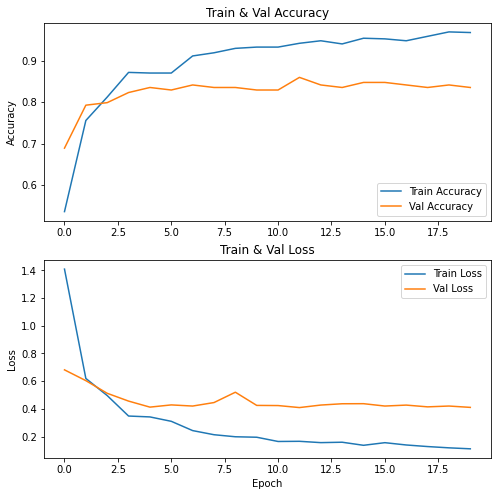

In [ ]:
plt.figure(figsize=(8, 8))

# Plot Accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history["categorical_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_categorical_accuracy"], label="Val Accuracy")
plt.title("Train & Val Accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Train & Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

## Fine-tune (optional)

In [ ]:
def Finetune(base_model):
  # Unfreeze layers
  base_model.trainable = True

  # Fine-tune starting from this layer
  start = 100
  for layer in base_model.layers[:start]:
    layer.trainable = False

In [ ]:
if (MODEL_NAME == 'mobilenet'):
  Finetune(base_model)
  model_mobilenet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 1,866,564
Non-tra

In [ ]:
def TrainFinetune(model, history, X_train, y_train, X_val, y_val, n_epochs):
  lr = tf.keras.optimizers.schedules.CosineDecay(0.00003, 500)
  #lr = 0.0001

  optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
  loss = tf.keras.losses.CategoricalCrossentropy()
  metric = tf.keras.metrics.CategoricalAccuracy()

  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
  fine_tune_epochs = 40
  fine_tune_n_epochs = n_epochs + fine_tune_epochs

  starting_epoch = history.epoch[-1] + 1
  fine_tune_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=fine_tune_n_epochs, initial_epoch=starting_epoch)
  return fine_tune_history

In [ ]:
fine_tune_history = None
if (MODEL_NAME == 'mobilenet'):
  fine_tune_history = TrainFinetune(model_mobilenet, history, X_train_run, y_train_run, X_val_run, y_val_run, n_epochs=20)

Epoch 21/60
21/21 [==============================] - 7s 67ms/step - loss: 1.9977 - categorical_accuracy: 0.5053 - val_loss: 0.4157 - val_categorical_accuracy: 0.8476
Epoch 22/60
21/21 [==============================] - 0s 20ms/step - loss: 1.5226 - categorical_accuracy: 0.5695 - val_loss: 0.4013 - val_categorical_accuracy: 0.8720
Epoch 23/60
21/21 [==============================] - 0s 20ms/step - loss: 1.1755 - categorical_accuracy: 0.6626 - val_loss: 0.3951 - val_categorical_accuracy: 0.8659
Epoch 24/60
21/21 [==============================] - 0s 20ms/step - loss: 0.8765 - categorical_accuracy: 0.7176 - val_loss: 0.3986 - val_categorical_accuracy: 0.8598
Epoch 25/60
21/21 [==============================] - 0s 18ms/step - loss: 0.7610 - categorical_accuracy: 0.7481 - val_loss: 0.3928 - val_categorical_accuracy: 0.8354
Epoch 26/60
21/21 [==============================] - 0s 19ms/step - loss: 0.6030 - categorical_accuracy: 0.7832 - val_loss: 0.3821 - val_categorical_accuracy: 0.8537
Epoc

### Plot graph

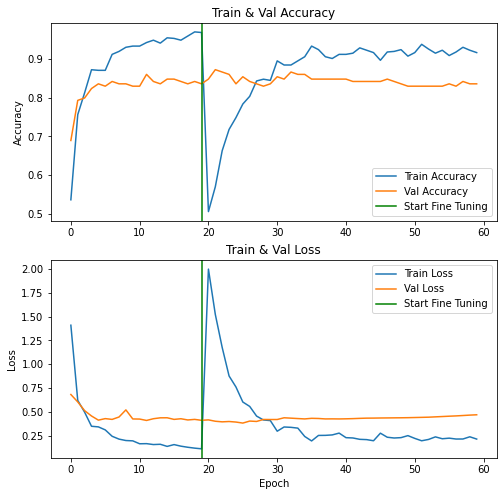

In [ ]:
if (MODEL_NAME == 'mobilenet'):
  n_epochs = 20
  plt.figure(figsize=(8, 8))

  # Plot Accuracy
  plt.subplot(2, 1, 1)
  plt.plot(history.history["categorical_accuracy"]+fine_tune_history.history["categorical_accuracy"], label="Train Accuracy")
  plt.plot(history.history["val_categorical_accuracy"]+fine_tune_history.history["val_categorical_accuracy"], label="Val Accuracy")
  #plt.plot([n_epochs-1, n_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.axvline(x=n_epochs-1, label="Start Fine Tuning", color='green')
  plt.title("Train & Val Accuracy")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")

  # Plot Loss
  plt.subplot(2, 1, 2)
  plt.plot(history.history["loss"]+fine_tune_history.history["loss"], label="Train Loss")
  plt.plot(history.history["val_loss"]+fine_tune_history.history["val_loss"], label="Val Loss")
  #plt.plot([n_epochs-1, n_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.axvline(x=n_epochs-1, label="Start Fine Tuning", color='green')
  plt.title("Train & Val Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

## Save Model

In [ ]:
def SaveModel(model, PATH):
  model.save(PATH)

if (MODEL_NAME == 'ann'):
  print('saved ann model')
  SaveModel(model_ann, MODEL_SAVE_PATH)
elif (MODEL_NAME == 'cnn'):
  print('saved cnn model')
  SaveModel(model_cnn, MODEL_SAVE_PATH)
else:
  print('saved mobilenet model')
  SaveModel(model_mobilenet, MODEL_SAVE_PATH)

## Plot the accuracy and loss

## Print Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def ShowConfusionMatrix(model, X_val, y_val):
  _dataset = X_val

  pred = model.predict(_dataset)
  y_pred = np.argmax(pred, axis=1)
  y_test = np.argmax(y_val, axis=1)
  print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['G','Y','M','V'])
  disp.plot()
  plt.show()

6/6 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        64
           1       0.65      0.58      0.61        26
           2       0.73      0.85      0.79        52
           3       0.94      0.68      0.79        22

    accuracy                           0.84       164
   macro avg       0.82      0.77      0.79       164
weighted avg       0.84      0.84      0.83       164



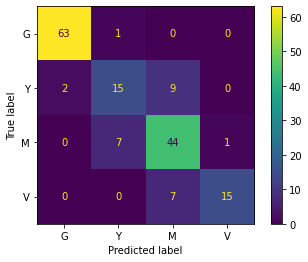

In [ ]:
if (MODEL_NAME == 'ann'):
  print('ann confusion matrix')
  ShowConfusionMatrix(model_ann, X_val_run, y_val_run)
elif (MODEL_NAME == 'cnn'):
  print('cnn confusion matrix')
  ShowConfusionMatrix(model_cnn, X_val_run, y_val_run)
else:
  print('mobilenet confusion matrix')
  ShowConfusionMatrix(model_mobilenet, X_val_run, y_val_run)

# 7. Predict Test Data

## Load Test Data

In [ ]:
#TO RUN: load dataset
PATH='test_data'
folder_name = os.listdir(PATH)
test_dataset = []

# Green 104 Yellowish_green 48 Midripen 88 Overripen 33
data_keys = ('g','y','m','v')
test_dataset_label = []

for name in sorted(folder_name):
  subfolder = os.path.join(PATH, name)
  for fh in sorted(os.listdir(subfolder)):
    file_name = os.path.join(subfolder,fh)
    print(file_name)
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)
    test_dataset.append(img)
    test_dataset_label.append(data_keys.index(fh[0]))

test_data/Green/g0004.jpg
test_data/Green/g0006.jpg
test_data/Green/g0007.jpg
test_data/Green/g0008.jpg
test_data/Green/g0009.jpg
test_data/Green/g0010.jpg
test_data/Green/g0011.jpg
test_data/Green/g0012.jpg
test_data/Green/g0013.jpg
test_data/Midripen/m0004.jpg
test_data/Midripen/m0005.jpg
test_data/Midripen/m0006.jpg
test_data/Midripen/m0007.jpg
test_data/Midripen/m0008.jpg
test_data/Midripen/m0009(1).jpg
test_data/Midripen/m0009.jpg
test_data/Midripen/m0010.jpg
test_data/Midripen/m0011.jpg
test_data/Midripen/m0012.png
test_data/Midripen/m0013.png
test_data/Midripen/m0014.png
test_data/Midripen/m0015.png
test_data/Overripen/v0001.jpg
test_data/Overripen/v0002.png
test_data/Overripen/v0003.png
test_data/Overripen/v0007.png
test_data/Overripen/v0008.png
test_data/Overripen/v0009.png
test_data/Overripen/v0010.png
test_data/Overripen/v0011.png
test_data/Overripen/v0012.png
test_data/Overripen/v0013.png
test_data/Yellowish_Green/y0003.jpg
test_data/Yellowish_Green/y0004.jpg
test_data/Yell

## Preprocess with gaussian blur and segment the image

In [ ]:
test_data_processed = np.array(list(map(ProcessImage, test_dataset)),dtype=object)
detect_masks, detect_boxes, detect_result = zip(*map(Proc, test_data_processed, repeat(0.862)))

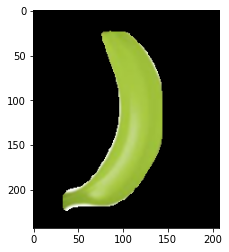

In [ ]:
test_data_segmented = list(map(SegmentImage, detect_masks, detect_boxes, test_data_processed))
plt.imshow(bgr2rgb(test_data_segmented[0]))

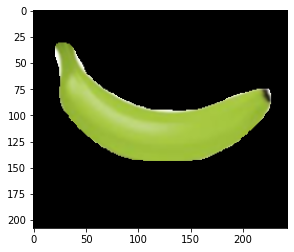

In [ ]:
plt.imshow(bgr2rgb(test_data_segmented[1]))

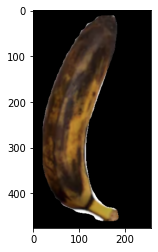

In [ ]:
plt.imshow(bgr2rgb(test_data_segmented[24]))

## Preprocess X data 
Resize and divide by 255 or [-1, 1] range depending on model name

In [ ]:
MODEL_LOAD_NAME = 'cnn'

In [ ]:
if (MODEL_LOAD_NAME == 'mobilenet'):
  test_data_s = PreprocessMobileNet(np.array(test_data_segmented))
  test_data_p = PreprocessMobileNet(np.array(test_data_processed))
else:
  test_data_s = Preprocess(np.array(test_data_segmented))
  test_data_p = Preprocess(np.array(test_data_processed))

In [ ]:
test_data_s.shape, test_data_p.shape

((40, 64, 64, 3), (40, 64, 64, 3))

## Preprocess y data

In [ ]:
test_data_label_s = OneHot(test_dataset_label)
test_data_label_p = OneHot(test_dataset_label)

In [ ]:
test_data_label_s.shape, test_data_label_p.shape

((40, 4), (40, 4))

## Load the model

Load which model to use and which dataset to use

1.   cnn_seg
2.   cnn_not_seg
3.   ann_seg
4.   ann_not_seg

dataset

1.   test_data_s, test_data_label_s
2.   test_data_p, test_data_label_p



In [ ]:
seg_bool_load = True
MODEL_LOAD_PATH = 'cnn_seg'

In [ ]:
test_data_run = None
test_data_label_run = None
if (seg_bool_load == False):
  print('not_segmented')
  test_data_run = test_data_p
  test_data_label_run = test_data_label_p
else:
  print('segmented')
  test_data_run = test_data_s
  test_data_label_run = test_data_label_s

segmented


In [ ]:
model_load = keras.models.load_model(MODEL_LOAD_PATH)

## Predict

In [ ]:
pred = np.argmax(model_load.predict(test_data_run), axis=1)
print(pred)

2/2 [==============================] - 0s 7ms/step
[1 0 0 1 1 1 1 0 1 2 2 2 2 2 2 2 2 2 3 3 3 2 3 3 3 3 3 2 2 3 3 3 1 2 1 2 2
 1 2 2]


In [ ]:
print(np.argmax(test_data_label_run, axis=1))

[0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1
 1 1 1]


In [ ]:
pred = model_load.evaluate(test_data_run, test_data_label_run)

2/2 [==============================] - 0s 14ms/step - loss: 1.9575 - categorical_accuracy: 0.6000


2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.33      0.38      0.35         8
           2       0.59      0.77      0.67        13
           3       0.73      0.80      0.76        10

    accuracy                           0.60        40
   macro avg       0.66      0.57      0.57        40
weighted avg       0.66      0.60      0.59        40



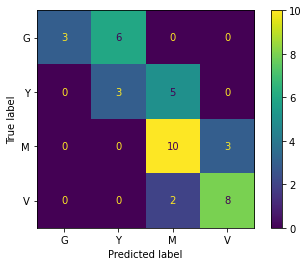

In [ ]:
ShowConfusionMatrix(model_load, test_data_run, test_data_label_run)

In [ ]:
# # img_test = cv2.imread('/content/864409.jpg',cv2.IMREAD_COLOR)
# # img_test = cv2.imread('/content/48164.jpg',cv2.IMREAD_COLOR)
# # img_test = cv2.imread('/content/ada.png',cv2.IMREAD_COLOR)
# # img_test = cv2.imread('/content/870480.jpg',cv2.IMREAD_COLOR)

# # filename = '/content/mom.png'
# # img_test = cv2.imread(filename, cv2.IMREAD_COLOR)
# # plt.imshow(bgr2rgb(img_test))
# # plt.show()
# # img_test = process_image(img_test)
# # _mask,_box,_res = proc(img_test, 0.862)

# # _seg = segment_image(_mask,_box,img_test)
# # # plt.imshow(bgr2rgb(img_test))
# # _seg.shape
# # _seg = np.array(_seg.reshape(1,*_seg.shape))
# # _seg.shape
# _dataset = PreprocessCNN(_seg)
# _dataset.shape
# pred = model_cnn.predict(_dataset)
# pred.shape
# resultt = np.argmax(pred,axis=1)
# def translator(res):
#     if (res == 0):
#         return 'Green'
#     if (res == 1):
#         return 'Midripen'
#     if (res == 2):
#         return 'Yellowish_green'
#     if (res == 3):
#         return 'Overripen'
#     else:
#         return "WRONG"
# print(translator(resultt))


In [ ]:

# img_test = cv2.imread('/content/864409.jpg',cv2.IMREAD_COLOR)
# img_test = cv2.imread('/content/48164.jpg',cv2.IMREAD_COLOR)
# img_test = cv2.imread('/content/ada.png',cv2.IMREAD_COLOR)
# img_test = cv2.imread('/content/870480.jpg',cv2.IMREAD_COLOR)

# filename = '/content/mom.png'
# img_test = cv2.imread(filename, cv2.IMREAD_COLOR)
# plt.imshow(bgr2rgb(img_test))
plt.show()
# img_test = process_image(img_test)
# _mask,_box,_res = proc(img_test, 0.862)

# _seg = segment_image(_mask,_box,img_test)
# plt.imshow(bgr2rgb(img_test))
# _seg.shape
# _seg = np.array(_seg.reshape(1,*_seg.shape))
# _seg.shape
# _dataset.shape
# X_val_s[0].shape
# plt.imshow(X_val_s[0])


In [ ]:
# !kill 3071
# %reload_ext tensorboard
# model_cnn.save('cnn_not_seg')

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir /content/drive/MyDrive/university/machine\ learning/logs/fit